In [24]:
import geohash
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
from importlib import reload

/home/yuwen/anaconda3/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [25]:
from rdforecast import datasets

path = './input/'
data = datasets.load_training_data()
print('TAZ:', len(data['geohash6'].unique()))
data = datasets.convert_datetime(data)
data.head()

'filepath' not given, download data from: https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
Data loaded.
N: 4206321
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
TAZ: 1329


,geohash6,day,timestamp,demand,date,time,datetime
0,qp03wc,18,20:0,0.020072,2018-01-19,20:00:00,2018-01-19 20:00:00
1,qp03pn,10,14:30,0.024721,2018-01-11,14:30:00,2018-01-11 14:30:00
2,qp09sw,9,6:15,0.102821,2018-01-10,06:15:00,2018-01-10 06:15:00
3,qp0991,32,5:0,0.088755,2018-02-02,05:00:00,2018-02-02 05:00:00
4,qp090q,15,4:0,0.074468,2018-01-16,04:00:00,2018-01-16 04:00:00


In [26]:
from shapely.geometry import Polygon
def geohash_to_polygon(hashcode):
    box = geohash.bbox(hashcode)
    vertices = [(box['w'], box['n']),
                (box['e'], box['n']),
                (box['e'], box['s']),
                (box['w'], box['s'])]
    return Polygon(vertices)

In [28]:
tazs = list(data['geohash6'].unique())
geometry = [geohash_to_polygon(taz) for taz in tazs]
shp = gpd.GeoDataFrame({'geohash6': tazs}, geometry=geometry)
shp.crs = {'init': 'epsg:4326'}
assert len(shp) == len(data['geohash6'].unique())
# shp.to_file('input/taz.shp')
# assertion
a = shp[shp['geohash6'] == 'qp03wc']['geometry'].values[0]
b = np.array([a.intersects(shp[shp['geohash6'] == gh]['geometry'].values[0])
              for gh in geohash.neighbors('qp03wc')])
assert sum(b == False) == 0

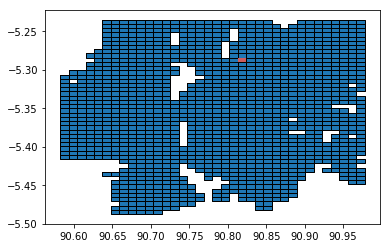

In [30]:
# shp['value'] = np.random.randn(len(shp))
# shp.plot(linewidth=1, edgecolor='black', column='value', cmap='viridis')
ax = shp.plot(linewidth=1, edgecolor='black')
shp[shp['geohash6'] == 'qp09ft'].plot(ax=ax, color='indianred')

In [29]:
data_['timestep'] = data_['timestep'].astype(int)
pivoted = data_.pivot(index='geohash6', columns='timestep', values='demand').reset_index()

NameError: name 'data_' is not defined

In [206]:
output = shp.merge(pivoted, how='left', on='geohash6')
output.columns = output.columns.astype(str)
assert len(shp) == len(pivoted) == len(output)

# output.iloc[:,:300].to_file('input/taz_timestep.shp')
# output[:700].to_file('input/taz_timestep.geojson', driver='GeoJSON')
# output.to_file('input/taz_timestep_all.geojson', driver='GeoJSON')
# output.to_csv('input/taz_timestep.csv', index=None)

In [59]:
res = {'qp09ft', 'qp03pn'}
k = set(np.ravel([geohash.neighbors(taz) for taz in res]))

In [76]:
def get_neighbors(taz, units=7):
    """Get units * units blocks centered at taz."""
    i = 0
    rounds = (units - 1) / 2
    res = {taz}
    new = {taz}
    while i < rounds:
        new = set(np.ravel([geohash.neighbors(t) for t in new]))
        res.update(new)
        i += 1
    assert len(res) == units ** 2
    return res

In [77]:
%%timeit
res = get_neighbors('qp09ft')

129 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
shp = gpd.read_file('input/taz_timestep.shp')
shp_qw = ps.queen_from_shapefile('input/taz_timestep.shp')
shp_qw.transform = 'r'

AttributeError: module 'pysal' has no attribute 'queen_from_shapefile'

In [11]:
shp = shp.to_crs(epsg=3857)
shp['geometry'][0].area

751131.1908622807

In [38]:
import matplotlib.pyplot as plt
%pylab inline

def compare_map(col1, col2):
    fig = plt.figure(figsize=(22,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    shp.plot(figsize=(10,6), vmax=0.7, column=col1, ax=ax1)
    shp.plot(figsize=(10,6), vmax=0.7, column=col2, ax=ax2)

In [53]:
ts = '200'
values = shp[ts]
lag = ps.lag_spatial(shp_qw, values)
# shp[ts+'_lag'] = values + 0.3 * lag
shp[ts+'_lag'] = lag

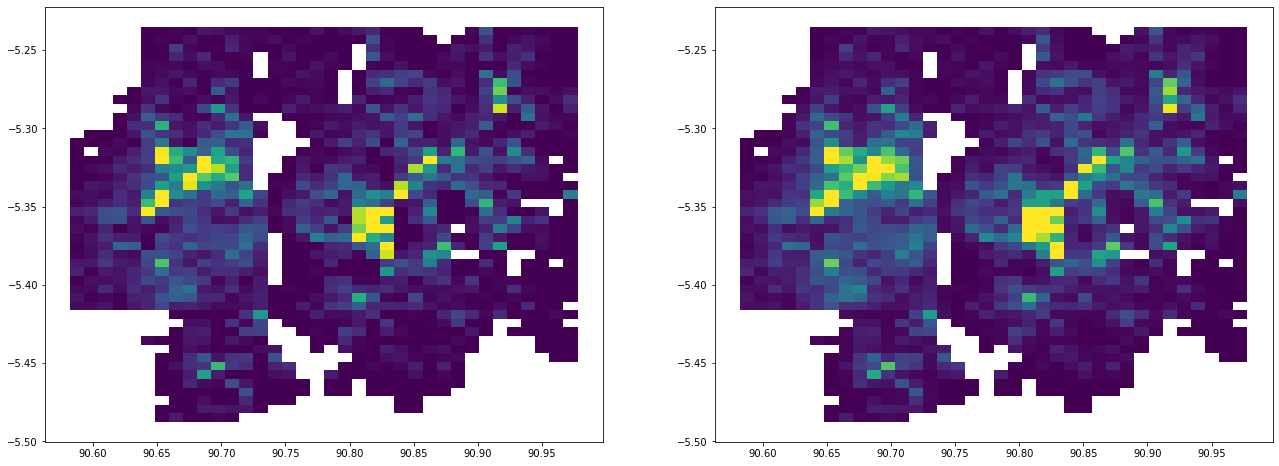

In [54]:
compare_map(ts, ts+'_lag')

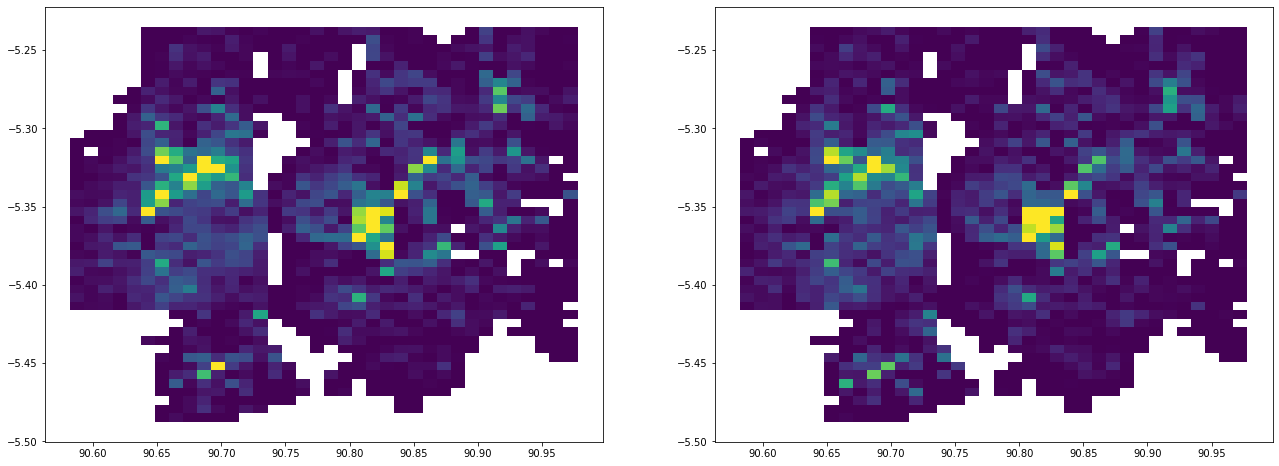

In [55]:
compare_map(str(int(ts)+1), str(int(ts)+4))

In [56]:
df = pd.read_csv('input/taz_timestep.csv')

In [57]:
df.head()

,geohash6,geometry,1,2,3,4,5,6,7,8,...,5847,5848,5849,5850,5851,5852,5853,5854,5855,5856
0,qp03wc,"POLYGON ((90.648193359375 -5.350341796875, 90....",0.054858,0.086209,0.050739,0.075174,0.062867,0.056765,0.069417,0.079853,...,0.034899,0.027943,0.029310,0.033446,0.018348,0.045894,0.068427,0.034809,0.059814,0.045901
1,qp03pn,"POLYGON ((90.6591796875 -5.4107666015625, 90.6...",NaN,0.005546,0.013577,0.004720,0.004425,0.000303,0.013996,0.004471,...,0.002006,0.004884,NaN,NaN,0.001958,0.000778,NaN,NaN,NaN,NaN
2,qp09sw,"POLYGON ((90.90087890625 -5.3228759765625, 90....",0.022881,0.019733,0.023053,0.029018,0.073814,0.066341,0.061355,0.094834,...,NaN,0.011049,0.015564,NaN,0.013121,NaN,0.005243,0.014848,0.007184,0.035813
3,qp0991,"POLYGON ((90.7470703125 -5.350341796875, 90.75...",0.012395,0.048042,0.078544,0.074393,0.117350,0.092151,0.061261,0.083871,...,0.009638,NaN,NaN,NaN,NaN,0.002199,0.030536,0.038095,0.058625,0.021198
4,qp090q,"POLYGON ((90.714111328125 -5.4107666015625, 90...",NaN,NaN,NaN,0.011483,0.003363,0.015389,0.016686,0.017399,...,0.000407,0.015546,NaN,0.002288,0.011023,0.008362,NaN,0.001531,NaN,NaN


In [61]:
corrtab = df.T.iloc[2:].corrtab()

In [69]:
dfT = df.T
dfT.columns = df['geohash6']

In [71]:
dfT = dfT.iloc[2:,:]
dfT = dfT.astype(float)

In [79]:
corrtab = dfT.corr()

In [81]:
corrtab.round(3).to_csv('output/taz_corr.csv')

In [ ]:
corrtab